# Team 27: Comparing Goodness of AR, MA, and ARIMA

Note: Some of the logic for this time series analysis/comparison was sourced from the following website:

https://medium.com/@stallonejacob/time-series-forecast-a-basic-introduction-using-python-414fcb963000

In [72]:
# Imports necessary packages
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pylab as plt
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
import warnings
warnings.simplefilter(action='ignore')
%matplotlib inline

In [2]:
# Loads training data into a dataframe and populates missing data with 0's
pd.set_option('display.max_rows', None, "display.max_columns", None)
path = r'./Data2/train_round2.csv'
df = pd.read_csv(path)
df.fillna(0.0, inplace=True)

In [3]:
# Transforms dataframe into a 3D array 
# Indexed by (state_id, days since April 12th 2020, type of information(confirmed/deaths/recovered/active/incident_rate/people_tested/people_hospitalized/mortality_rate/testing_rate/hospitalization_rate)
num_rows = len(df.index)
num_cols= len(df.columns)
data_set = np.zeros(shape=(50, num_rows//50, num_cols-3))
states_list = list()
dates_list = list()

for i in range(50):
    states_list.append(df.iloc[i, 1])

for i in range(num_rows):
    if (i%50 == 0):
        dates_list.append(df.iloc[i, 2])
    for j in range(num_cols-3):
        data_set[i%50][int(i/50)][j] = df.iloc[i, j+3]    
        data_set[i%50][int(i/50)][j] = df.iloc[i, j+3]

In [4]:
# Tests if dataframe loaded correctly; output should be 3563.0, 8.0, and 249.0 respectively
print(data_set[0][0][0])
print(data_set[1][1][1])
print(data_set[2][2][2])

# Output should be 04-12-2020 and 11-22-2020 respectively
print(dates_list[0])
print(dates_list[(num_rows//50)-1])

3563.0
8.0
249.0
04-12-2020
11-22-2020


In [5]:
# Converts list of dates to a dataframe
converted_dates_list = pd.to_datetime(dates_list)
dates_df = pd.DataFrame(converted_dates_list, columns=['Date'])
dates_df.head(10)

,Date
0,2020-04-12
1,2020-04-13
2,2020-04-14
3,2020-04-15
4,2020-04-16
5,2020-04-17
6,2020-04-18
7,2020-04-19
8,2020-04-20
9,2020-04-21


In [6]:
# Creates two tables that displays the cases and deaths for each state with respect to the date
cases_table = dates_df.copy(deep=True)
deaths_table = dates_df.copy(deep=True)

for state_index in range(50):
    state_name = states_list[state_index]
    one_state_cases = []
    for date_index in range(num_rows//50):
        one_state_cases.append(data_set[state_index][date_index][0]) 
    if state_name in cases_table:
        cases_table.drop(axis=1, labels=state_index+1)
        cases_table.insert(state_index+1, state_name, one_state_cases)
    else:
        cases_table.insert(state_index+1, state_name, one_state_cases)
        
for state_index in range(50):
    state_name = states_list[state_index]
    one_state_cases = []
    for date_index in range(num_rows//50):
        one_state_cases.append(data_set[state_index][date_index][1]) 
    if state_name in deaths_table:
        deaths_table.drop(axis=1, labels=state_index+1)
        deaths_table.insert(state_index+1, state_name, one_state_cases)
    else:
        deaths_table.insert(state_index+1, state_name, one_state_cases)

In [7]:
# Drops data after certain data (modify for different predictions)
# last_date_index = 142 for september predictions, num_rows//50 for final week predictions
last_date_index = 142
cases_table = cases_table.drop(index=list(range(last_date_index, num_rows//50)))
deaths_table = deaths_table.drop(index=list(range(last_date_index, num_rows//50)))

In [8]:
# Converts cases table to time series (and replaces 0's with 1's for divide by 0 errors)
cases_ts = cases_table.set_index('Date')
cases_ts = cases_ts.mask(cases_ts==0).fillna(1)
cases_ts.head(10)

,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,Florida,Georgia,Hawaii,Idaho,Illinois,Indiana,Iowa,Kansas,Kentucky,Louisiana,Maine,Maryland,Massachusetts,Michigan,Minnesota,Mississippi,Missouri,Montana,Nebraska,Nevada,New Hampshire,New Jersey,New Mexico,New York,North Carolina,North Dakota,Ohio,Oklahoma,Oregon,Pennsylvania,Rhode Island,South Carolina,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-04-12,3563.0,272.0,3542.0,1280.0,22795.0,7307.0,12035.0,1625.0,19895.0,12452.0,499.0,1407.0,20852.0,7928.0,1587.0,1344.0,1963.0,20595.0,633.0,8225.0,25475.0,24244.0,1621.0,2781.0,4269.0,387.0,791.0,2836.0,929.0,61850.0,1245.0,189033.0,4570.0,308.0,6604.0,1970.0,1527.0,22938.0,2665.0,3320.0,730.0,5508.0,13677.0,2303.0,727.0,5274.0,10609.0,593.0,3341.0,270.0
2020-04-13,3734.0,277.0,3705.0,1410.0,23931.0,7691.0,13381.0,1758.0,21019.0,13315.0,504.0,1426.0,22025.0,8359.0,1710.0,1390.0,2018.0,21016.0,698.0,8936.0,26867.0,25635.0,1621.0,2942.0,4515.0,394.0,814.0,2990.0,985.0,64584.0,1262.0,195749.0,4886.0,331.0,6975.0,2069.0,1584.0,24292.0,2665.0,3391.0,868.0,5610.0,14275.0,2363.0,748.0,5747.0,10635.0,611.0,3428.0,275.0
2020-04-14,3953.0,285.0,3809.0,1498.0,25356.0,7950.0,13989.0,1926.0,21628.0,14578.0,511.0,1464.0,23248.0,8527.0,1899.0,1441.0,2048.0,21518.0,735.0,9472.0,28164.0,27001.0,1695.0,3087.0,4746.0,399.0,897.0,3134.0,922.0,68824.0,1345.0,203020.0,5113.0,341.0,7285.0,2184.0,1633.0,25465.0,3251.0,3553.0,988.0,5827.0,15006.0,2417.0,752.0,6182.0,10799.0,640.0,3555.0,282.0
2020-04-15,4075.0,293.0,3964.0,1569.0,26686.0,7956.0,14755.0,2014.0,22511.0,14987.0,524.0,1473.0,24593.0,8960.0,1995.0,1504.0,2210.0,21951.0,770.0,10032.0,29918.0,28059.0,1809.0,3360.0,4791.0,404.0,901.0,3211.0,1139.0,71030.0,1484.0,214454.0,5340.0,365.0,7794.0,2263.0,1663.0,26753.0,3251.0,3656.0,1168.0,5827.0,15907.0,2548.0,759.0,6500.0,10942.0,702.0,3721.0,287.0
2020-04-16,4345.0,300.0,4237.0,1620.0,27677.0,8286.0,15884.0,2070.0,23343.0,15669.0,530.0,1587.0,25734.0,9542.0,2141.0,1615.0,2435.0,22532.0,796.0,10784.0,32181.0,28809.0,1809.0,3624.0,5174.0,415.0,952.0,3214.0,1139.0,75317.0,1484.0,223691.0,5639.0,393.0,8414.0,2357.0,1736.0,28258.0,3529.0,3931.0,1311.0,6375.0,16876.0,2683.0,774.0,6889.0,11057.0,728.0,3875.0,296.0
2020-04-17,4571.0,309.0,4511.0,1695.0,29157.0,8691.0,16809.0,2317.0,24759.0,17194.0,541.0,1609.0,27578.0,10154.0,2332.0,1730.0,2522.0,23118.0,827.0,11572.0,34402.0,30023.0,2070.0,3793.0,5371.0,422.0,1066.0,3524.0,1287.0,78467.0,1597.0,230597.0,6045.0,393.0,9107.0,2465.0,1785.0,29888.0,4177.0,4099.0,1411.0,6263.0,17849.0,2793.0,779.0,7491.0,11517.0,775.0,4053.0,305.0
2020-04-18,4712.0,314.0,4724.0,1744.0,30491.0,9047.0,17550.0,2538.0,25492.0,17669.0,574.0,1655.0,29160.0,10641.0,2513.0,1821.0,2707.0,23580.0,847.0,12326.0,36372.0,30791.0,2209.0,3974.0,5579.0,426.0,1249.0,3626.0,1342.0,81420.0,1798.0,241712.0,6328.0,528.0,10222.0,2465.0,1844.0,31652.0,4491.0,4248.0,1542.0,6589.0,18704.0,2917.0,803.0,8053.0,11776.0,785.0,4199.0,309.0
2020-04-19,4888.0,319.0,4933.0,1781.0,31431.0,9730.0,17962.0,2538.0,26314.0,18301.0,580.0,1668.0,30357.0,11211.0,2902.0,1905.0,2960.0,23928.0,867.0,12847.0,38077.0,31424.0,2356.0,4274.0,5743.0,433.0,1474.0,3728.0,1390.0,85301.0,1845.0,247815.0,6601.0,585.0,11602.0,2567.0,1910.0,32902.0,4706.0,4377.0,1635.0,7070.0,19260.0,3069.0,813.0,8542.0,12255.0,890.0,4346.0,313.0
2020-04-20,5079.0,321.0,5068.0,1973.0,33686.0,9730.0,19815.0,2745.0,27059.0,19407.0,584.0,1672.0,31513.0,11688.0,3159.0,2048.0,3050.0,24523.0,875.0,13684.0,38077.0,32000.0,2470.0,4512.0,5890.0,433.0,1648.0,3830.0,1447.0,88722.0,1971.0,253060.0,6895.0,627.0,12919.0,2680.0,1957.0,33914.0,5090.0,4446.0,1685.0,7238.0,19751.0,3213.0,816.0,8990.0,12114.0,902.0,4499.0,317.0


In [9]:
# Converts deaths table to time series (and replaces 0's with 1's for divide by 0 errors)
deaths_ts = deaths_table.set_index('Date')
deaths_ts = deaths_ts.mask(deaths_ts==0).fillna(1)
deaths_ts.head(10)

,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,Florida,Georgia,Hawaii,Idaho,Illinois,Indiana,Iowa,Kansas,Kentucky,Louisiana,Maine,Maryland,Massachusetts,Michigan,Minnesota,Mississippi,Missouri,Montana,Nebraska,Nevada,New Hampshire,New Jersey,New Mexico,New York,North Carolina,North Dakota,Ohio,Oklahoma,Oregon,Pennsylvania,Rhode Island,South Carolina,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-04-12,93.0,8.0,115.0,27.0,640.0,289.0,554.0,35.0,461.0,433.0,9.0,27.0,720.0,343.0,41.0,56.0,97.0,840.0,19.0,236.0,756.0,1479.0,70.0,96.0,118.0,6.0,17.0,112.0,23.0,2350.0,26.0,9385.0,89.0,7.0,253.0,96.0,52.0,557.0,63.0,82.0,6.0,106.0,283.0,18.0,27.0,141.0,506.0,6.0,144.0,1.0
2020-04-13,99.0,8.0,122.0,29.0,714.0,306.0,602.0,41.0,499.0,465.0,9.0,27.0,798.0,350.0,41.0,62.0,113.0,884.0,19.0,262.0,844.0,1602.0,70.0,98.0,123.0,7.0,17.0,114.0,23.0,2443.0,26.0,10058.0,94.0,8.0,274.0,99.0,53.0,589.0,63.0,82.0,6.0,109.0,305.0,13.0,28.0,149.0,513.0,8.0,154.0,1.0
2020-04-14,114.0,9.0,131.0,32.0,767.0,327.0,671.0,43.0,571.0,525.0,9.0,33.0,868.0,387.0,49.0,69.0,106.0,1013.0,20.0,302.0,844.0,1768.0,79.0,111.0,149.0,7.0,20.0,126.0,25.0,2805.0,31.0,10842.0,112.0,8.0,324.0,108.0,55.0,691.0,80.0,97.0,6.0,124.0,342.0,18.0,29.0,154.0,530.0,9.0,170.0,1.0
2020-04-15,118.0,9.0,142.0,33.0,860.0,328.0,868.0,46.0,596.0,552.0,9.0,39.0,949.0,436.0,53.0,71.0,115.0,1103.0,24.0,311.0,1108.0,1921.0,87.0,122.0,153.0,7.0,20.0,131.0,32.0,3156.0,36.0,11617.0,130.0,9.0,362.0,123.0,58.0,779.0,80.0,106.0,6.0,124.0,375.0,20.0,29.0,195.0,552.0,10.0,183.0,1.0
2020-04-16,133.0,9.0,150.0,37.0,956.0,355.0,971.0,55.0,668.0,587.0,9.0,41.0,1072.0,477.0,60.0,80.0,129.0,1156.0,27.0,319.0,1108.0,1996.0,87.0,129.0,169.0,7.0,21.0,137.0,32.0,3518.0,36.0,14832.0,150.0,9.0,407.0,131.0,64.0,841.0,87.0,111.0,7.0,136.0,414.0,20.0,33.0,208.0,579.0,12.0,197.0,2.0
2020-04-17,148.0,9.0,169.0,37.0,1037.0,372.0,1036.0,61.0,725.0,650.0,9.0,41.0,1132.0,522.0,64.0,82.0,137.0,1213.0,29.0,334.0,1245.0,2227.0,111.0,140.0,184.0,8.0,24.0,142.0,37.0,3840.0,44.0,17131.0,177.0,9.0,418.0,136.0,70.0,921.0,118.0,116.0,7.0,141.0,451.0,23.0,35.0,231.0,603.0,16.0,206.0,2.0
2020-04-18,153.0,9.0,180.0,38.0,1140.0,389.0,1086.0,67.0,748.0,673.0,9.0,43.0,1259.0,545.0,74.0,85.0,144.0,1267.0,32.0,421.0,1404.0,2308.0,121.0,152.0,197.0,10.0,24.0,151.0,38.0,4070.0,53.0,17671.0,187.0,9.0,451.0,136.0,72.0,1042.0,137.0,119.0,7.0,142.0,476.0,25.0,38.0,258.0,613.0,16.0,212.0,2.0
2020-04-19,157.0,9.0,184.0,39.0,1177.0,420.0,1127.0,67.0,774.0,687.0,10.0,44.0,1290.0,562.0,75.0,93.0,146.0,1296.0,34.0,461.0,1706.0,2391.0,134.0,159.0,199.0,10.0,28.0,158.0,38.0,4362.0,55.0,18298.0,200.0,9.0,471.0,140.0,74.0,1276.0,150.0,120.0,7.0,148.0,490.0,27.0,38.0,277.0,636.0,18.0,220.0,2.0
2020-04-20,163.0,9.0,191.0,41.0,1225.0,420.0,1331.0,72.0,822.0,775.0,10.0,45.0,1349.0,577.0,79.0,102.0,154.0,1328.0,35.0,582.0,1706.0,2468.0,143.0,169.0,200.0,10.0,33.0,159.0,42.0,4496.0,58.0,18611.0,218.0,9.0,509.0,143.0,75.0,1348.0,155.0,123.0,7.0,152.0,507.0,28.0,38.0,300.0,643.0,24.0,230.0,2.0


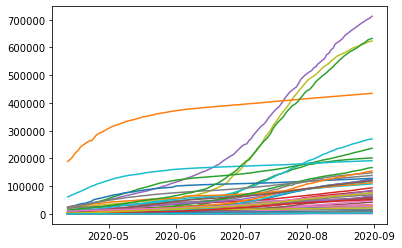

In [28]:
# Plots number of cases vs time
_ = plt.plot(cases_ts)

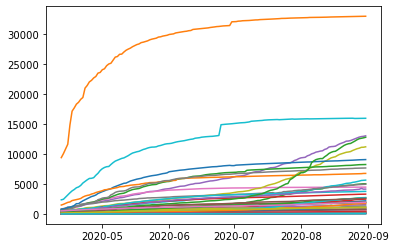

In [29]:
# Plots number of deaths vs time
_ = plt.plot(deaths_ts)

In [31]:
#  Creates 50 cases and 50 deaths time series, one for each state and stores them in two lists
cases_ts_list = []
deaths_ts_list = []
for i in range(50):
    cases_ts_list.append(cases_ts[states_list[i]].copy())
    deaths_ts_list.append(deaths_ts[states_list[i]].copy())

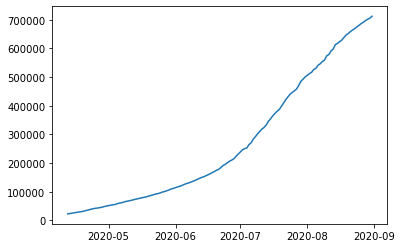

In [13]:
# Test plot for California's cases
_ = plt.plot(cases_ts_list[4])

In [32]:
# Use log to reduce the strong positive trend
cases_ts_log_list = []
deaths_ts_log_list = []
for i in range(50):
    cases_ts_log_list.append(np.log(cases_ts_list[i]))
    deaths_ts_log_list.append(np.log(deaths_ts_list[i]))

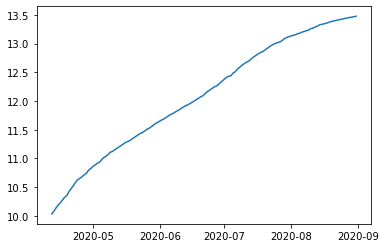

In [33]:
# Tests ts_log plot for California
_ = plt.plot(cases_ts_log_list[4])

In [106]:
# Calculates exponential weighted moving average
cases_ewma_list = []
deaths_ewma_list = []
for i in range(50):
    cases_ewma_list.append(cases_ts_log_list[i].ewm(span=12).mean())
    deaths_ewma_list.append(deaths_ts_log_list[i].ewm(span=12).mean())

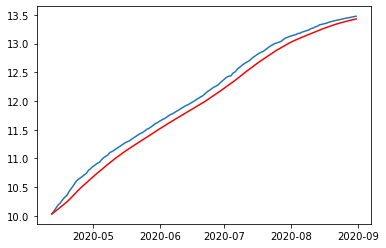

In [107]:
# Plots ewma for cases in California
plt.plot(cases_ts_log_list[4])
plt.plot(cases_ewma_list[4], color='red')

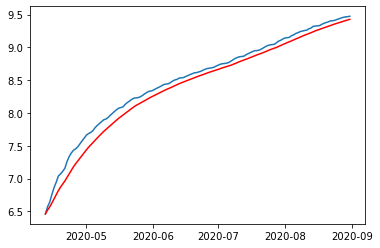

In [108]:
# Plots ewma for deaths in California
plt.plot(deaths_ts_log_list[4])
plt.plot(deaths_ewma_list[4], color='red')

In [109]:
# Calculates ewma difference for cases and deaths in all states
cases_ewma_diff_list = []
deaths_ewma_diff_list = []
for i in range(50):
    cases_ewma_diff_list.append(cases_ts_log_list[i] - cases_ewma_list[i])
    deaths_ewma_diff_list.append(deaths_ts_log_list[i] - deaths_ewma_list[i])

In [110]:
# Checks ewma difference for cases in California
cases_ewma_diff_list[4].head(14)

Date
2020-04-12    0.000000
2020-04-13    0.022290
2020-04-14    0.048856
2020-04-15    0.068420
2020-04-16    0.076386
2020-04-17    0.097252
2020-04-18    0.110305
2020-04-19    0.111312
2020-04-20    0.144871
2020-04-21    0.159130
2020-04-22    0.172192
2020-04-23    0.188995
2020-04-24    0.192827
2020-04-25    0.180074
Name: California, dtype: float64

In [111]:
# Modified version of utility function from source site mentioned at the beginning of the notebook
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

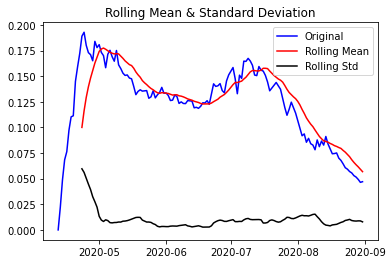

Results of Dickey-Fuller Test:
Test Statistic                  -1.910265
p-value                          0.327248
#Lags Used                       7.000000
Number of Observations Used    134.000000
Critical Value (1%)             -3.480119
Critical Value (5%)             -2.883362
Critical Value (10%)            -2.578407
dtype: float64


In [112]:
# Tests stationarity of California for cases
test_stationarity(cases_ewma_diff_list[4])

Conclusion: Because the test statistic does not even fall under the 90% confidence range, adjusting for trend alone won't be sufficient for forecasting.

In [113]:
# Accounts for seasonal trends using time lag
cases_ts_log_diff_list = []
deaths_ts_log_diff_list = []
for i in range(50):
    cases_ts_log_diff_list.append(cases_ts_log_list[i] - cases_ts_log_list[i].shift())
    cases_ts_log_diff_list[i].dropna(inplace=True)
    deaths_ts_log_diff_list.append(deaths_ts_log_list[i] - deaths_ts_log_list[i].shift())
    deaths_ts_log_diff_list[i].dropna(inplace=True)

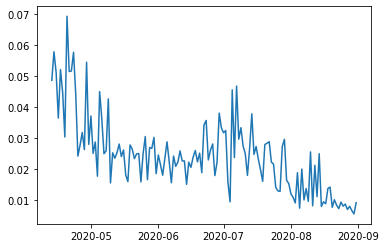

In [114]:
# Tests seasonality for California's cases using the difference method
plt.plot(cases_ts_log_diff_list[4])

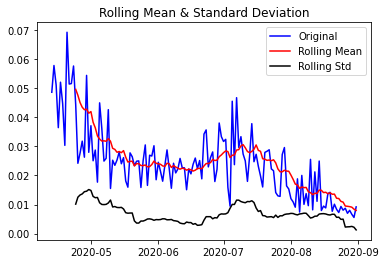

Results of Dickey-Fuller Test:
Test Statistic                  -2.544627
p-value                          0.104990
#Lags Used                       9.000000
Number of Observations Used    131.000000
Critical Value (1%)             -3.481282
Critical Value (5%)             -2.883868
Critical Value (10%)            -2.578677
dtype: float64


In [115]:
# Tests stationarity of California for cases after accounting for seasonality
test_stationarity(cases_ts_log_diff_list[4])

Conclusion: Because the test statistic nearly falls under the 90% confidence level, adjusting for seasonality is definitely neccessary. Using decomposition to also account for the trend will likely generate a sufficiently stationary dataset, as subtracting the ewma from the original plot was also a step in the right direction.

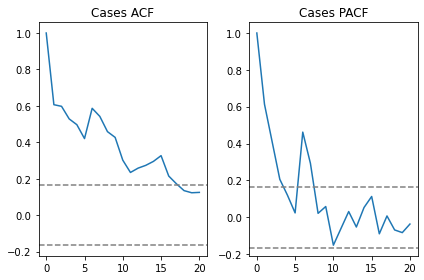

In [55]:
# For cases
# Use autocorrelation function and partial autocorrelation function to determine parameters for ARIMA
# Use California's graph to determine p and q values since it has the largest population
cases_lag_acf = acf(cases_ts_log_diff_list[4], nlags=20)
cases_lag_pacf = pacf(cases_ts_log_diff_list[4], nlags=20, method='ols')

plt.subplot(121)
plt.plot(cases_lag_acf)
plt.axhline(y=1.96/np.sqrt(len(cases_ts_log_diff_list[4])), linestyle = '--', color='grey')
plt.axhline(y=-1.96/np.sqrt(len(cases_ts_log_diff_list[4])), linestyle = '--', color='grey')
plt.title('Cases ACF')

plt.subplot(122)
plt.plot(cases_lag_pacf)
plt.axhline(y=1.96/np.sqrt(len(cases_ts_log_diff_list[4])), linestyle = '--', color='grey')
plt.axhline(y=-1.96/np.sqrt(len(cases_ts_log_diff_list[4])), linestyle = '--', color='grey')
plt.title('Cases PACF')
plt.tight_layout()

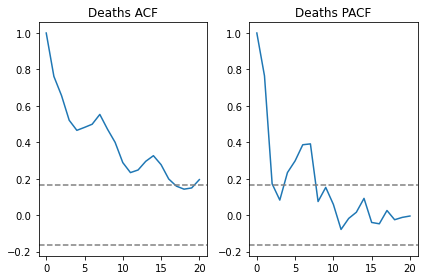

In [54]:
# For deaths
# Use autocorrelation function and partial autocorrelation function to determine parameters for ARIMA
# Use California's graph to determine p and q values since it has the largest population
deaths_lag_acf = acf(deaths_ts_log_diff_list[4], nlags=20)
deaths_lag_pacf = pacf(deaths_ts_log_diff_list[4], nlags=20, method='ols')

plt.subplot(121)
plt.plot(deaths_lag_acf)
plt.axhline(y=1.96/np.sqrt(len(deaths_ts_log_diff_list[4])), linestyle = '--', color='grey')
plt.axhline(y=-1.96/np.sqrt(len(deaths_ts_log_diff_list[4])), linestyle = '--', color='grey')
plt.title('Deaths ACF')

plt.subplot(122)
plt.plot(deaths_lag_pacf)
plt.axhline(y=1.96/np.sqrt(len(deaths_ts_log_diff_list[4])), linestyle = '--', color='grey')
plt.axhline(y=-1.96/np.sqrt(len(deaths_ts_log_diff_list[4])), linestyle = '--', color='grey')
plt.title('Deaths PACF')
plt.tight_layout()

From where the graphs crossed the positive confidence threshold, we can see that the p and q values are:

Cases: p = 17, q = 3

Deaths: p =16, q = 2

In [73]:
# Measure goodness using RSS of AR model for cases for California
cases_AR_model = ARIMA(cases_ts_log_list[4], order=(17, 1, 0))
cases_results_AR = cases_AR_model.fit(disp=-1)
print('cases AR RSS: ', sum((cases_results_AR.fittedvalues - cases_ts_log_diff_list[4])**2))

cases AR RSS:  0.007244642121076855


In [74]:
# Measure goodness using RSS of MA model for cases for Californa
cases_MA_model = ARIMA(cases_ts_log_list[4], order=(0, 1, 3))
cases_results_MA = cases_MA_model.fit(disp=-1)
print('cases MA RSS: ', sum((cases_results_MA.fittedvalues - cases_ts_log_diff_list[4])**2))

cases MA RSS:  0.011807475533867497


In [77]:
# Measure goodness using RSS of ARIMA model for cases for Californa
cases_ARIMA_model = ARIMA(cases_ts_log_list[4], order=(17, 1, 3))
cases_results_ARIMA = cases_ARIMA_model.fit(disp=-1)
print('cases ARIMA RSS: ', sum((cases_results_ARIMA.fittedvalues - cases_ts_log_diff_list[4])**2))

cases ARIMA RSS:  0.0070835617527382514


In [89]:
# Measure goodness using RSS of AR model for deaths for California
deaths_AR_model = ARIMA(deaths_ts_log_list[4], order=(16, 1, 0))
deaths_results_AR = deaths_AR_model.fit(disp=-1)
print('deaths AR RSS: ', sum((deaths_results_AR.fittedvalues - deaths_ts_log_diff_list[4])**2))

deaths AR RSS:  0.014764436774820979


In [84]:
# Measure goodness using RSS of MA model for deaths for Californa
deaths_MA_model = ARIMA(deaths_ts_log_list[4], order=(0, 1, 2))
deaths_results_MA = deaths_MA_model.fit(disp=-1)
print('deaths MA RSS: ', sum((deaths_results_MA.fittedvalues - deaths_ts_log_diff_list[4])**2))

deaths MA RSS:  0.031828859194954595


In [85]:
# Measure goodness using RSS of ARIMA model for deaths for Californa
deaths_ARIMA_model = ARIMA(deaths_ts_log_list[4], order=(16, 1, 2))
deaths_results_ARIMA = deaths_ARIMA_model.fit(disp=-1)
print('deaths ARIMA RSS: ', sum((deaths_results_ARIMA.fittedvalues - deaths_ts_log_diff_list[4])**2))

deaths ARIMA RSS:  0.01646365910850634


With respect to California, the ARIMA algorithm gave us the lowest RSS value for the number of cases, but the AR algorithm gave us the lowest RSS value for the number of deaths. However, both values for number of cases and deaths are similar enough to suggest that the choice between AR and ARIMA varies between states. Choosing one algorithm for all 50 states would probably result in underfitting.

In [90]:
# Cases: get predicted values and store as series for each state
case_predictions_diff_list = []
for i in range(50):
    temp_model = ARIMA(cases_ts_log_list[i], order=(17, 1, 0))
    temp_results = temp_model.fit(disp=-1)
    case_predictions_diff_list.append(pd.Series(temp_results.fittedvalues, copy=True))

In [101]:
print(case_predictions_diff_list[4].head())

Date
2020-04-13    0.025976
2020-04-14    0.043437
2020-04-15    0.049632
2020-04-16    0.050701
2020-04-17    0.046786
dtype: float64


In [103]:
# Cases: convert differencing to log scale
case_predictions_diff_cumsum_list = []
for i in range(50):
    case_predictions_diff_cumsum_list.append(case_predictions_diff_list[i].cumsum())

In [104]:
print(case_predictions_diff_cumsum_list[4].head())

Date
2020-04-13    0.025976
2020-04-14    0.069413
2020-04-15    0.119045
2020-04-16    0.169746
2020-04-17    0.216531
dtype: float64


In [119]:
# Cases: predict cases
predictions_list = []
for i in range(50):
    temp_prediction = pd.Series(cases_ts_log_list[i], index=cases_ts_log_list[i].index)
    temp_prediction = temp_prediction.add(case_predictions_diff_cumsum_list[i], fill_value=0)
    temp_prediction = np.exp(temp_prediction)
    predictions_list.append(temp_prediction)

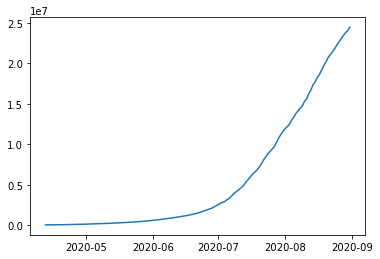

In [125]:
plt.plot(predictions_list[4])

TODO: Analyze why predictions results are off